In [135]:
#!pip install nltk


from imblearn.over_sampling import SMOTE

# Import the required libraires
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt

%matplotlib inline

import re

# Pre-processing library
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# Models 
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier



# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# df = pd.read_csv("/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv",sep="\t")
df = pd.read_csv('./data/amazon_alexa.tsv', sep='\t')
print(df.shape)
df.head()

(3150, 5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sicom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sicom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sicom\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sicom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [136]:
# Drop unrelated columns
df = df.drop(['date','variation','rating'],axis=1)
df = df.drop_duplicates('verified_reviews')
print(df.describe(include='all'))
df.info()


       verified_reviews     feedback
count              2301  2301.000000
unique             2301          NaN
top       Love my Echo!          NaN
freq                  1          NaN
mean                NaN     0.910474
std                 NaN     0.285564
min                 NaN     0.000000
25%                 NaN     1.000000
50%                 NaN     1.000000
75%                 NaN     1.000000
max                 NaN     1.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301 entries, 0 to 2800
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   verified_reviews  2301 non-null   object
 1   feedback          2301 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.9+ KB


In [137]:
class ml_model():

    def __init__(self,  model='xgboost',vectorizer='tfidf'):
        
        self.vectorizer_type = vectorizer    
        if vectorizer == 'tfidf':
            self.vectorizer = TfidfVectorizer()
        elif vectorizer == 'word2vec':
            self.vectorizer = gensim.models.Word2Vec(min_count=2,
                     vector_size=5000)
            
        self.model_type = model
        if model == 'xgboost':
            self.model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.9, subsample=0.7,learning_rate=0.0000000005)
        elif model == 'svm':
            self.model = svm.SVC(class_weight='balanced')
        elif model == 'rfc':
            self.model = RandomForestClassifier(class_weight='balanced')
        elif model == 'nb':
            self.model = GaussianNB()
            
#         self.pipeline = Pipeline([ ('vectorizer', self.vectorizer), ('model',self.model)]) 

        
        self.stopwords = set(stopwords.words('english'))
        self.stopwords.remove('not')
        self.stopwords.add('')
#         self.stopwords.remove('nor')
        
        
    def load_data(self, df):
        self.df = df.copy()
    
    def clean_review(self, review):
        review = word_tokenize(review)
        review = [rev.lower() for rev in review]
        review = [re.sub("[^A-Za-z0-9]",' ',rev) for rev in review]
        review = [re.sub(r'[0-9]+',' ',rev) for rev in review]
        review = " ".join(WordNetLemmatizer().lemmatize(i) for i in review if i not in self.stopwords)
        
        if self.vectorizer_type == 'tfidf':
            return review
        else:
            return review.split()

    def preprocess(self, x):
        self.data = [self.clean_review(rev) for rev in x]
        
        return self.data
    
    def vectorize_data(self, x):
        if self.vectorizer_type == 'tfidf':
            return self.vectorizer.transform(x)
        elif self.vectorizer_type == 'word2vec':
            x = [self.vectorizer.wv[i] for i in x]
            return x
        
        
    def train(self, x, y):
        x = self.preprocess(x)
        
        if self.vectorizer_type == 'word2vec':
            self.vectorizer.build_vocab(x, progress_per=10000)
            self.vectorizer.train(x, total_examples=self.vectorizer.corpus_count, epochs=2)
        else:
            self.vectorizer.fit_transform(x)
        x = self.vectorize_data(x)
#         self.oversample(x,y)
        
        if self.model_type == 'nb':
            self.model.fit(x.toarray(),y)
        else:
            self.model.fit(x,y)
        
    def oversample(self, x, y):
        return SMOTE().fit_resample(x,y)
        
    def score(self, x_test, y_test,score=True):
        x_test = self.preprocess(x_test)
        
        x_test = self.vectorize_data(x_test)
        
        if self.model_type == 'nb':
            y_pred = self.model.predict(x_test.toarray())
        else:
            y_pred = self.model.predict(x_test)
        
        if score:
            print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')
            print(f'The F1 score is: {f1_score(y_test, y_pred, average="macro")*100}')
            print(f'The precision score is: {precision_score(y_test, y_pred, average="macro")*(100)}')
            print(f'The recall score is: {recall_score(y_test, y_pred, average="macro")*100}') 
            print(f'The accuracy score is: {accuracy_score(y_test, y_pred)*100}\n\n\n')

        print(f'AUC score is: {roc_auc_score(y_test,y_pred)}')
        
        return y_pred
        
    def predict(self, x):
        x = self.clean_review(x)
        
        x = self.vectorize_data([x])
        
        return(self.model.predict(x))
    
    def get_params(self):
        return self.pipeline.get_params()
    
    def draw_roc(self, x, y,score=False):
        
        
        y_pred = self.score(x,y,score)
        
        clf_fpr, clf_tpr, threshold = roc_curve(y, y_pred)
        auc_clf = auc(clf_fpr, clf_tpr)
        
        plt.figure(figsize=(5, 5), dpi=100)
        plt.plot(clf_fpr, clf_tpr, linestyle='-', label='clf (auc = %0.3f)' % auc_clf)

        plt.xlabel('False Positive Rate -->')
        plt.ylabel('True Positive Rate -->')

        plt.legend()

        plt.show()
        

In [138]:
x_train, x_test ,y_train,y_test = train_test_split(df['verified_reviews'],df['feedback'],test_size=0.2,random_state=42, stratify=df['feedback'])

In [139]:

mymodel1 = ml_model('xgboost','tfidf')
mymodel1.train(x_train, y_train)

mymodel2 = ml_model('svm', 'tfidf')
mymodel2.train(x_train, y_train)

AUC score is: 0.7072590011614401


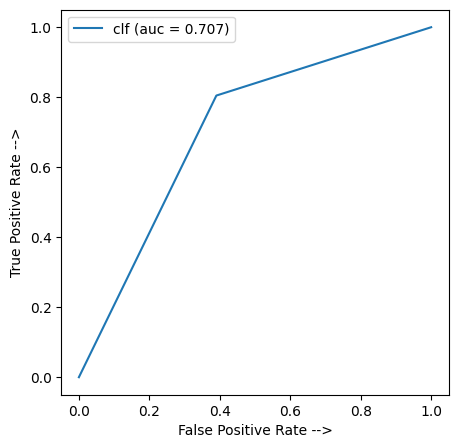

AUC score is: 0.5806039488966318


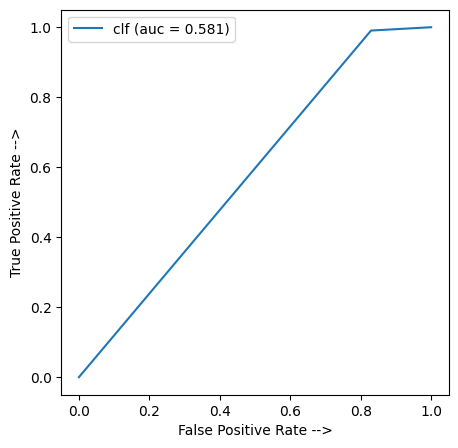

In [140]:
mymodel1.draw_roc(x_test,y_test)
mymodel2.draw_roc(x_test,y_test)

In [141]:
print(mymodel1.predict('love it'))

[1]


In [142]:
import pickle

pickle.dump(mymodel1,open('model','wb'))

In [143]:
predict = pickle.load(open('model','rb'))

In [145]:
print(predict.predict('terrible it'))

[0]
